In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
import joblib  # For saving ARIMA and SARIMA model

import warnings
warnings.filterwarnings("ignore")

In [30]:
# Load cleaned data and filter for TSLA
cleaned_df = pd.read_csv('cleaned_data.csv', parse_dates=['Date'])
tsla_data = cleaned_df[cleaned_df['tickers'] == 'TSLA']
# Use only the 'Close' column
data = tsla_data.set_index('Date')['Close']

In [31]:
# Split the data into training and testing sets
train_size = int(len(data) * 0.8)
train, test = data[:train_size], data[train_size:]

# Function to evaluate model performance
def evaluate_model(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return mae, rmse, mape

In [42]:
# Train ARIMA Model
print("🔄 Starting ARIMA model training...")
arima_model = ARIMA(train, order=(5, 1, 0))
arima_fit = arima_model.fit()
print("✅ ARIMA model training completed successfully! 🎉")

# Forecast ARIMA
arima_forecast = arima_fit.forecast(steps=len(test))
arima_mae, arima_rmse, arima_mape = evaluate_model(test, arima_forecast)

# Train SARIMA Model
print("🌾 Starting SARIMA model training...")
sarima_model = SARIMAX(train, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
sarima_fit = sarima_model.fit()
print("✅ SARIMA model training completed successfully! 🎉")
# Forecast SARIMA
sarima_forecast = sarima_fit.forecast(steps=len(test))
sarima_mae, sarima_rmse, sarima_mape = evaluate_model(test, sarima_forecast)

🔄 Starting ARIMA model training...
✅ ARIMA model training completed successfully! 🎉
🌾 Starting SARIMA model training...
✅ SARIMA model training completed successfully! 🎉


In [43]:
# Display ARIMA model summary (similar to console output)
print(arima_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 1936
Model:                 ARIMA(5, 1, 0)   Log Likelihood               -6176.748
Date:                Sat, 09 Aug 2025   AIC                          12365.496
Time:                        16:44:15   BIC                          12398.903
Sample:                             0   HQIC                         12377.783
                               - 1936                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0317      0.013     -2.383      0.017      -0.058      -0.006
ar.L2          0.0192      0.012      1.647      0.100      -0.004       0.042
ar.L3         -0.0007      0.015     -0.047      0.9

In [44]:
# Display SARIMA model summary (if needed)
print(sarima_fit.summary())

                                     SARIMAX Results                                      
Dep. Variable:                              Close   No. Observations:                 1936
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -6171.528
Date:                            Sat, 09 Aug 2025   AIC                          12353.057
Time:                                    16:44:15   BIC                          12380.865
Sample:                                         0   HQIC                         12363.288
                                           - 1936                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4841      0.263     -1.837      0.066      -1.000       0.032
ma.L1          0.4501      0.270   

In [45]:
# Prepare data for LSTM
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_train = scaler.fit_transform(train.values.reshape(-1, 1))
scaled_test = scaler.transform(test.values.reshape(-1, 1))

In [46]:
# Create sequences for LSTM
def create_dataset(data, time_step=1):
    X, Y = [], []
    for i in range(len(data) - time_step - 1):
        X.append(data[i:(i + time_step), 0])
        Y.append(data[i + time_step, 0])
    return np.array(X), np.array(Y)

time_step = 10
X_train, y_train = create_dataset(scaled_train, time_step)
X_test, y_test = create_dataset(scaled_test, time_step)

# Reshape input for LSTM
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

### # Train LSTM Model

In [53]:
# Train LSTM Model
lstm_model = Sequential()
lstm_model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
lstm_model.add(Dropout(0.2))  # Adding Dropout for regularization
lstm_model.add(LSTM(50))
lstm_model.add(Dropout(0.2))  # Adding Dropout for regularization
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mean_squared_error')
# Model summary (to reflect console output)
lstm_model.summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_18 (LSTM)                  │ (None, 10, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 10, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_19 (LSTM)                  │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,651 (119.73 KB)

 Trainable params: 30,651 (119.73 KB)

 Non-trainable params: 0 (0.00 B)

In [54]:
# Fit the model
lstm_model.fit(X_train, y_train, epochs=50, batch_size=32)
# Forecast LSTM
lstm_pred = lstm_model.predict(X_test)
lstm_pred = scaler.inverse_transform(lstm_pred)  # Inverse transform to original scale
lstm_mae, lstm_rmse, lstm_mape = evaluate_model(test.values[time_step + 1:], lstm_pred)

Epoch 1/50


61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0161
Epoch 2/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0023
Epoch 3/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0024
Epoch 4/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0021
Epoch 5/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0021
Epoch 6/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0019
Epoch 7/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0019
Epoch 8/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0018
Epoch 9/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0019
Epoch 10/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0020
Epoch 11/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0017
Epoch 12/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0014
Epoch 13/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0015
Epoch 14/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0015
Epoch 15/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0016
Epoch 16/50
61/61 ━━━━━━━━━━━━

In [59]:
# Print evaluation results
print(f"ARIMA - MAE: {arima_mae}, RMSE: {arima_rmse}, MAPE: {arima_mape}")
print(f"SARIMA - MAE: {sarima_mae}, RMSE: {sarima_rmse}, MAPE: {sarima_mape}")
print(f"LSTM - MAE: {lstm_mae}, RMSE: {lstm_rmse}, MAPE: {lstm_mape}")


ARIMA - MAE: 56.493133472735636, RMSE: 70.51097434323124, MAPE: nan
SARIMA - MAE: 57.4196658191316, RMSE: 68.48810105150957, MAPE: nan
LSTM - MAE: 12.513468607283546, RMSE: 17.51304350654685, MAPE: 30.398148825585153


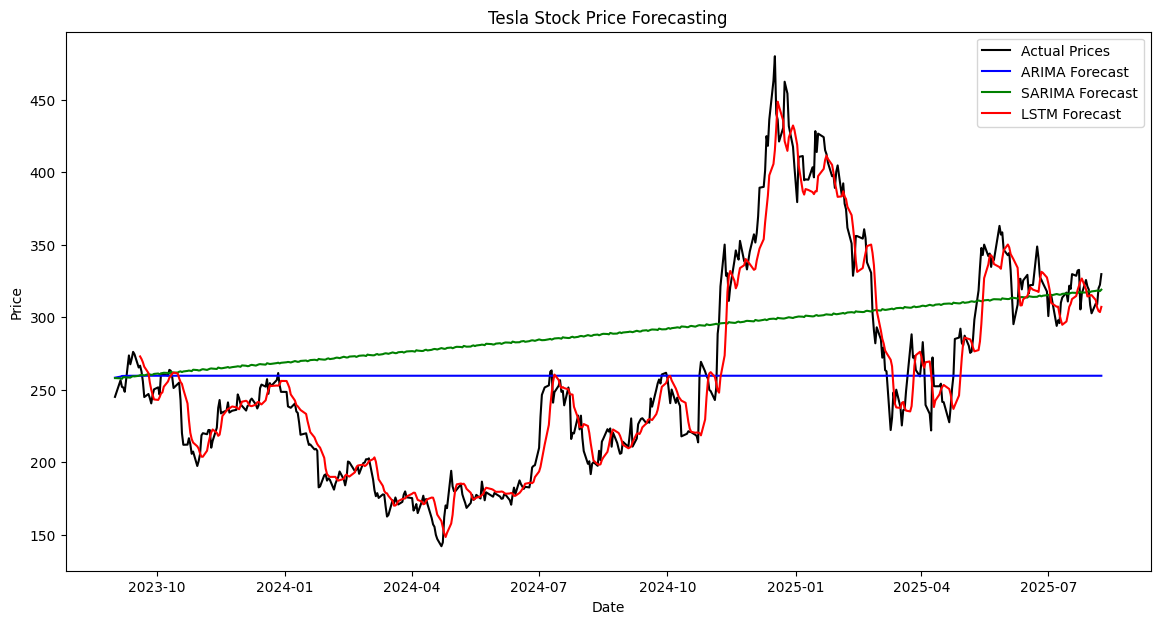

In [60]:
# Plot predictions
plt.figure(figsize=(14, 7))
plt.plot(test.index, test.values, label='Actual Prices', color='black')
plt.plot(test.index, arima_forecast, label='ARIMA Forecast', color='blue')
plt.plot(test.index, sarima_forecast, label='SARIMA Forecast', color='green')
plt.plot(test.index[time_step + 1:], lstm_pred, label='LSTM Forecast', color='red')
plt.title('Tesla Stock Price Forecasting')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


In [76]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import itertools

# Define parameter ranges for grid search
p = d = q = range(0, 15)  # AR, differencing, MA orders
P = D = Q = range(0, 15)  # Seasonal AR, differencing, MA orders
m = 12  # Seasonal period (e.g., 12 for monthly data)

# Create a list of all possible combinations of parameters
pdq = list(itertools.product(p, d, q))
PDQ = list(itertools.product(P, D, Q))

best_aic = float("inf")
best_order = None
best_seasonal_order = None
best_model = None

# Grid search for the best parameters
for order in pdq:
    for seasonal_order in PDQ:
        try:
            model = SARIMAX(train, order=order, seasonal_order=seasonal_order)
            results = model.fit()
            
            # Compare AIC values to find the best model
            if results.aic < best_aic:
                best_aic = results.aic
                best_order = order
                best_seasonal_order = seasonal_order
                best_model = results
        except Exception as e:
            continue

# Display the best model parameters
print(f"Best SARIMA order: {best_order}")
print(f"Best seasonal order: {best_seasonal_order}")
print(f"Best AIC: {best_aic}")

Best SARIMA order: None
Best seasonal order: None
Best AIC: inf


In [79]:

from statsmodels.tsa.arima.model import ARIMA
import itertools


# Define parameter ranges for grid search
p = d = q = range(0, 5)  # AR, differencing, MA orders

# Create a list of all possible combinations of parameters
pdq = list(itertools.product(p, d, q))

best_aic = float("inf")
best_order = None
best_model = None

# Grid search for the best parameters
for order in pdq:
    try:
        model = ARIMA(train, order=order)
        results = model.fit()
        
        # Compare AIC values to find the best model
        if results.aic < best_aic:
            best_aic = results.aic
            best_order = order
            best_model = results
    except Exception as e:
        continue

# Display the best model parameters
print(f"Best ARIMA order: {best_order}")
print(f"Best AIC: {best_aic}")

# Forecast using the best model
arima_forecast = best_model.forecast(steps=len(test))

# Calculate Mean Squared Error
arima_mse = mean_squared_error(test, arima_forecast)
print(f"Mean Squared Error of ARIMA Forecast: {arima_mse:.2f}")

Best ARIMA order: (2, 2, 3)
Best AIC: 12330.007647984816
Mean Squared Error of ARIMA Forecast: 4664.40


In [ ]:
# Optimize ARIMA parameters using auto_arima
print("🔄 Starting ARIMA parameter optimization...")
arima_model = pm.auto_arima(train, seasonal=False, stepwise=True, trace=True)
# Display the summary of the best ARIMA model
print(arima_model.summary())
# Forecast using the optimized ARIMA model
arima_forecast = arima_model.predict(n_periods=len(test))
# Calculate and display the Mean Squared Error (MSE) for ARIMA
arima_mse = mean_squared_error(test, arima_forecast)
print(f"Mean Squared Error of ARIMA Forecast: {arima_mse:.2f}")

In [ ]:
from sklearn.model_selection import ParameterGrid
def create_lstm_model(units, dropout_rate):
    model = Sequential()
    model.add(LSTM(units=units, return_sequences=True, input_shape=(X_train.shape[1], 1)))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(units=units))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

In [68]:
# Define a grid of hyperparameters to search
param_grid = {
    'units': [50, 64, 80],  # Number of LSTM units
    'dropout_rate': [0.2, 0.3],  # Dropout rates
    'epochs': [30, 50],  # Number of epochs
    'batch_size': [16, 32]  # Batch sizes
}

# Store results
results = []

# Iterate over all combinations of parameters
for params in ParameterGrid(param_grid):
    print(f"🔄 Training LSTM with params: {params}")
    
    model = create_lstm_model(units=params['units'], dropout_rate=params['dropout_rate'])
    
    # Fit the model
    history = model.fit(X_train, y_train, 
                        epochs=params['epochs'], 
                        batch_size=params['batch_size'], 
                        verbose=0)
    
    # Evaluate the model
    lstm_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, lstm_pred)
    results.append((params, mse))

# Find the best parameters based on the lowest MSE
best_params = min(results, key=lambda x: x[1])
print(f"✅ Best LSTM parameters: {best_params[0]} with MSE: {best_params[1]}")

🔄 Training LSTM with params: {'batch_size': 16, 'dropout_rate': 0.2, 'epochs': 30, 'units': 50}
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
🔄 Training LSTM with params: {'batch_size': 16, 'dropout_rate': 0.2, 'epochs': 30, 'units': 64}
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
🔄 Training LSTM with params: {'batch_size': 16, 'dropout_rate': 0.2, 'epochs': 30, 'units': 80}
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
🔄 Training LSTM with params: {'batch_size': 16, 'dropout_rate': 0.2, 'epochs': 50, 'units': 50}
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
🔄 Training LSTM with params: {'batch_size': 16, 'dropout_rate': 0.2, 'epochs': 50, 'units': 64}
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
🔄 Training LSTM with params: {'batch_size': 16, 'dropout_rate': 0.2, 'epochs': 50, 'units': 80}
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
🔄 Training LSTM with params: {'batch_size': 16, 'dropout_rate': 0.3, 'epochs': 30, 'units': 50}
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
🔄 Training LSTM with params: {'batch_size': 16, 

In [61]:
save_path = '../model/arima_model.pkl'
# Save ARIMA model
joblib.dump(arima_fit, save_path)
print(f"ARIMA model saved to {save_path}")

save_path = '../model/sarima_model.pkl'
# Save SARIMA model
joblib.dump(sarima_fit, save_path)
print(f"SARIMA model saved to {save_path}")

save_path = '../model/lstm_model.h5'
# Save LSTM model
lstm_model.save(save_path)
print(f"LSTM model saved to {save_path}")

ARIMA model saved to ../model/arima_model.pkl


SARIMA model saved to ../model/sarima_model.pkl
LSTM model saved to ../model/lstm_model.h5
